In [15]:
print("""
@File         : modeling_volatility_with_garch_class_models.ipynb
@Author(s)    : Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime  : 2024-03-02 23:05:35
@Email        : cuixuanstephen@gmail.com
@Description  : 使用 GARCH 类模型对波动率进行建模
""")


@File         : modeling_volatility_with_garch_class_models.ipynb
@Author(s)    : Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime  : 2024-03-02 23:05:35
@Email        : cuixuanstephen@gmail.com
@Description  : 使用 GARCH 类模型对波动率进行建模



## Modeling stock returns’ volatility with ARCH models

\begin{equation}
\begin{aligned}
r_t &= \mu+\epsilon_t\\
\epsilon_t&=\sigma_tz_t\\
\sigma_t^2&=\omega+\sum_{i=1}^q\alpha_i\epsilon_{t-1}^2\\
\end{aligned}
\end{equation}

In [16]:
import pandas as pd
import yfinance as yf
from arch import arch_model
import matplotlib.pyplot as plt

In [17]:
RISKY_ASSET = 'GOOG'
START_DATE = '2015-01-01'
END_DATE = '2021-12-31'

In [18]:
df = yf.download(RISKY_ASSET,
                 start=START_DATE, 
                 end=END_DATE,
                 auto_adjust=True)
if df.empty:
    df = pd.read_csv('../data/GOOG_20150101_20211231.csv', index_col=['Date'], parse_dates=['Date'])

Failed to get ticker 'GOOG' reason: Expecting value: line 1 column 1 (char 0)


[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['GOOG']: Exception('%ticker%: No timezone found, symbol may be delisted')


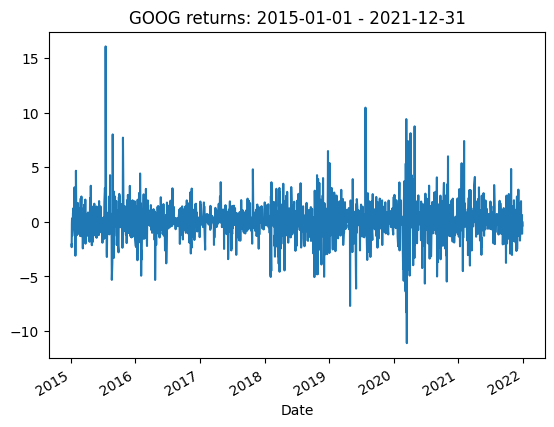

In [19]:
returns = 100 * df['Adj Close'].pct_change().dropna()
returns.name = 'asset_returns'
returns.plot(
    title=f'{RISKY_ASSET} returns: {START_DATE} - {END_DATE}'
)
plt.show()

In [20]:
model = arch_model(returns, mean='zero', vol='ARCH', p=1, q=0)

In [21]:
# suppress output from the optimization steps
fitted_model = model.fit(disp='off')
print(fitted_model.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:          asset_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:               -3301.32
Distribution:                  Normal   AIC:                           6606.64
Method:            Maximum Likelihood   BIC:                           6617.59
                                        No. Observations:                 1761
Date:                Sun, Mar 03 2024   Df Residuals:                     1761
Time:                        13:25:15   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          1.8608      0.166     11.207  3.786e-29 [  1.535,  2.18

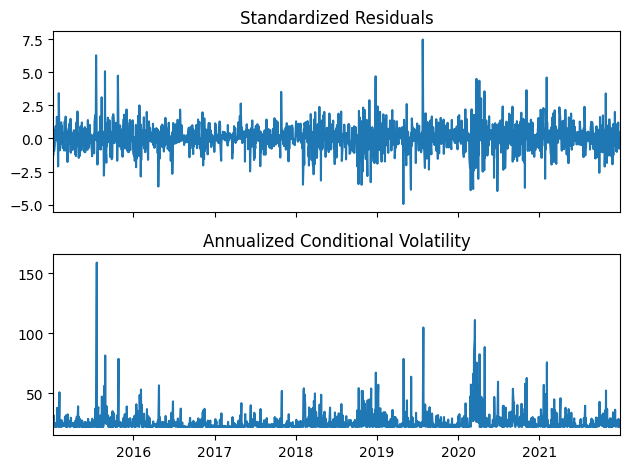

In [22]:
# annualize the conditional volatility series from daily data.
fitted_model.plot(annualize='D')
plt.tight_layout()

we confirm that the standardized residuals are simply residuals divided by the conditional volatility.

In [23]:
diagnostics_dict = {
    'resids': fitted_model.resid,
    'conditional_volatility': fitted_model.conditional_volatility,
    'std_resid': fitted_model.std_resid,
    'std_resid_manual': fitted_model.resid / fitted_model.conditional_volatility,
}
df_diagnostics = pd.DataFrame(data=diagnostics_dict)
df_diagnostics.head()

,resids,conditional_volatility,std_resid,std_resid_manual
Date,,,,
2015-01-05,-2.084559,1.661243,-1.254819,-1.254819
2015-01-06,-2.317709,1.874594,-1.236379,-1.236379
2015-01-07,-0.171323,1.976011,-0.086702,-0.086702
2015-01-08,0.315304,1.368190,0.230453,0.230453
2015-01-09,-1.295055,1.377898,-0.939877,-0.939877


In [24]:
from statsmodels.stats.diagnostic import het_arch
het_arch(fitted_model.resid)


(98.039222223998,
 1.344224948074281e-16,
 10.320163004670732,
 4.3555236163186665e-17)

The first two values in the tuple are the LM test statistic and its corresponding p-value. The latter two are the f-statistic for the F test (an alternative approach to testing for ARCH effects) and its corresponding p-value. We can see that both p-values are below the customary significance level of 0.05, which leads us to reject the null hypothesis stating that the residuals are homoskedastic. This means that the ARCH(1) model fails to capture all ARCH effects in the residuals.

## 使用 GARCH 模型对股票回报波动率进行建模

GARCH can be considered an ARMA model applied to the variance of a time series—the AR component was already expressed in the ARCH model, while GARCH additionally adds the moving average part.

The equation of the GARCH model can be presented as:

\begin{equation}
\begin{aligned}
r_t &= \mu+\epsilon_t\\
\epsilon_t&=\sigma_tz_t\\
\sigma_t^2&=\omega+\sum_{i=1}^q\alpha_i\epsilon_{t-1}^2+\sum_{i=1}^p\beta_i\sigma_{t-1}^2\\
\end{aligned}
\end{equation}

Parameters are constrained to meet the following: $\omega > 0$, $\alpha_i \geq 0$, and $\beta_i\geq 0$.

In the GARCH model, there are additional constraints on coefficients. For example, in the case of a GARCH(1, 1) model, $\alpha_i + \beta_i$ must be less than 1. Otherwise, the model is unstable.


In [25]:
model = arch_model(returns, mean='zero', vol='GARCH', p=1, q=1)

In [28]:
fitted_model = model.fit(disp='off')
print(fitted_model.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:          asset_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -3245.30
Distribution:                  Normal   AIC:                           6496.61
Method:            Maximum Likelihood   BIC:                           6513.03
                                        No. Observations:                 1761
Date:                Sun, Mar 03 2024   Df Residuals:                     1761
Time:                        13:45:16   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.2878      0.187      1.540      0.123 [-7.83

According to **Market Risk Analysis**, the usual range of values of the parameters in a stable market would be $0.05 < \alpha < 0.01$ and $0.85 < \beta < 0.98$ . However, we should keep in mind that while these ranges will most likely not strictly apply, they already give us some idea of what kinds of values we should be expecting.

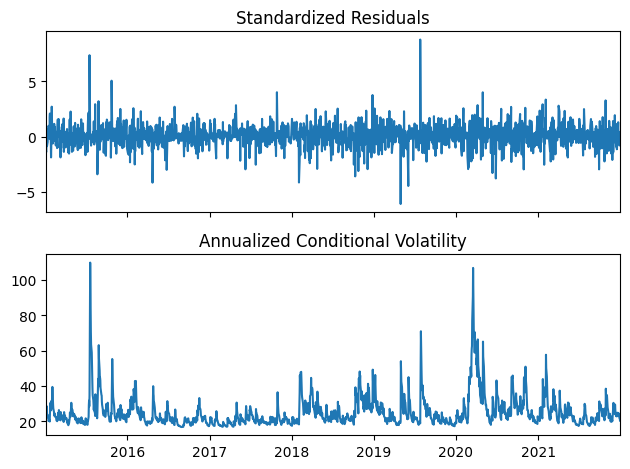

In [30]:
fitted_model.plot(annualize='D')
plt.tight_layout()

## Forecasting volatility using GARCH models

There are three approaches to forecasting volatility using GARCH class models:
- Analytical — due to the inherent structure of ARCH class models, analytical forecasts are always available for the one step-ahead forecast. Multi-step analytical forecasts can be obtained using a forward recursion; however, that is only possible for models that are linear in the square of the residuals (such as GARCH or Heterogeneous ARCH).
- Simulation—simulation-based forecasts use the structure of an ARCH class model to forward simulate possible volatility paths using the assumed distribution of residuals. In other words, they use random number generators (assuming specific distributions) to draw the standardized residuals. This approach creates x possible volatility paths and then produces the average as the final forecast. Simulation-based forecasts are always available for any horizon. As the number of simulations increases toward infinity, the simulation-based forecasts will converge to the analytical forecasts.
- Bootstrap (also known as the Filtered Historical Simulation)—those forecasts are very similar to the simulation-based forecasts with the difference that they generate (to be precise, draw with replacement) the standardized residuals using the actual input data and the estimated parameters. This approach requires a minimal amount of in-sample data to use prior to producing the forecasts.

we fit a GARCH(1,1) model with Student’s t distributed residuals to Microsoft’s stock returns from the years 2015 to 2020. Then, we create 3-step ahead forecasts for each day of 2021.

In [34]:
from datetime import datetime

In [32]:
df = pd.read_csv('../data/MSFT_20150101_20211231.csv', index_col='Date', parse_dates=['Date'])
returns = 100 * df['Adj Close'].pct_change().dropna()
returns.name = 'asset_returns'

In [33]:
# Specify the GARCH model:
model = arch_model(returns, mean='Zero', vol='GARCH', dist='t', p=1, q=1)

In [35]:
# Define the split date and fit the model:
SPLIT_DATE = datetime(2021, 1, 1)
fitted_model = model.fit(last_obs=SPLIT_DATE, disp='off')

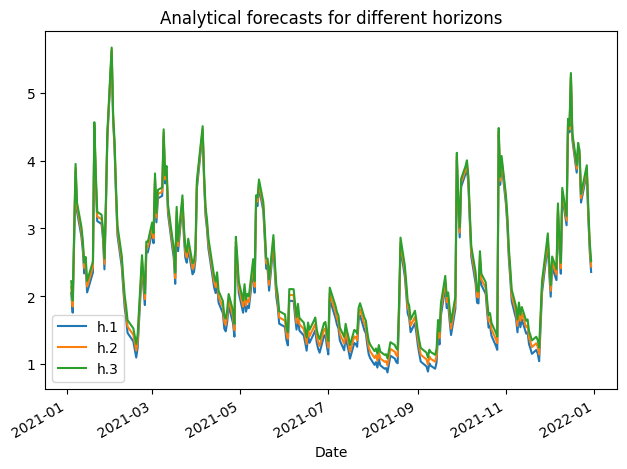

In [38]:
# Create and inspect the analytical forecasts:
forecasts_analytical = fitted_model.forecast(horizon=3, start=SPLIT_DATE,
                                             reindex=False)
forecasts_analytical.variance.plot(
    title='Analytical forecasts for different horizons'
)
plt.tight_layout()

In [39]:
forecasts_analytical.variance

,h.1,h.2,h.3
Date,,,
2021-01-04,2.048955,2.134412,2.218515
2021-01-05,1.754025,1.844160,1.932866
2021-01-06,2.770916,2.844923,2.917756
2021-01-07,3.838391,3.895467,3.951638
2021-01-08,3.248854,3.315281,3.380654
...,...,...,...
2021-12-23,3.380795,3.445129,3.508442
2021-12-27,3.817178,3.874590,3.931092
2021-12-28,3.185601,3.253030,3.319391


Each column contains the h-step ahead forecasts generated on the date indicated by the index. When the forecasts are created, the date from the Date column corresponds to the last data point used to generate the forecasts. For example, the columns with the date 2021-01-08 contain the forecasts for January 9, 10, and 11. Those forecasts were created using data up to and including January 8.

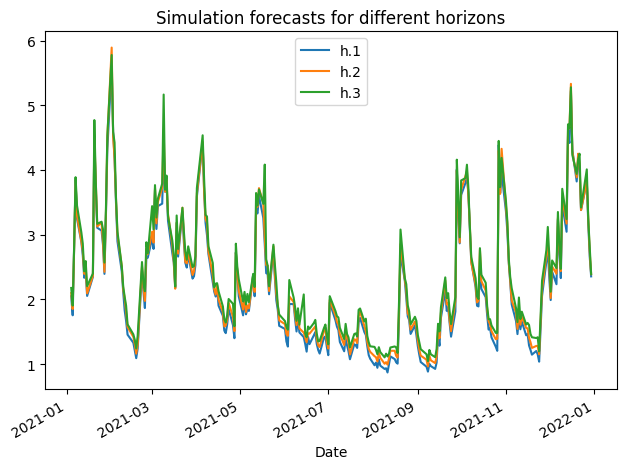

In [42]:
# Create and inspect the simulation forecasts:
forecasts_simulation = fitted_model.forecast(
    horizon=3, start=SPLIT_DATE, method='simulation', reindex=False
)
forecasts_simulation.variance.plot(
    title='Simulation forecasts for different horizons'
)
plt.tight_layout()

In [43]:
forecasts_simulation.variance

,h.1,h.2,h.3
Date,,,
2021-01-04,2.048955,2.097361,2.176770
2021-01-05,1.754025,1.850713,1.904606
2021-01-06,2.770916,2.780134,2.827163
2021-01-07,3.838391,3.843474,3.888581
2021-01-08,3.248854,3.295119,3.449414
...,...,...,...
2021-12-23,3.380795,3.380125,3.420026
2021-12-27,3.817178,3.826086,4.009066
2021-12-28,3.185601,3.252911,3.242934


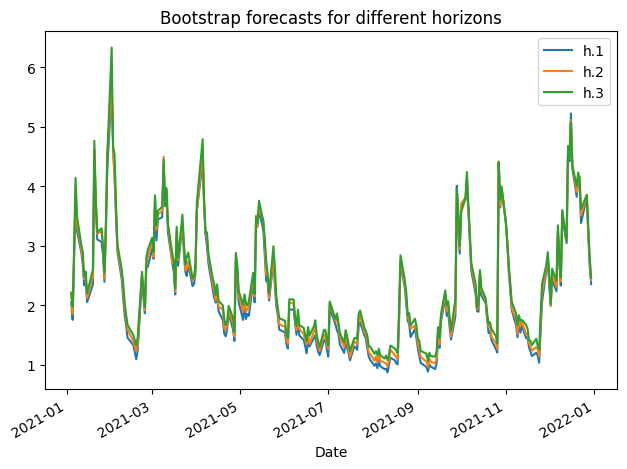

In [46]:
# Create and inspect the bootstrap forecasts:
forecasts_bootstrap = fitted_model.forecast(
    horizon=3, start=SPLIT_DATE, method='bootstrap', reindex=False
)
forecasts_bootstrap.variance.plot(
    title='Bootstrap forecasts for different horizons'
)
plt.tight_layout()

In [47]:
forecasts_bootstrap.variance

,h.1,h.2,h.3
Date,,,
2021-01-04,2.048955,2.215285,2.203381
2021-01-05,1.754025,1.859667,1.973483
2021-01-06,2.770916,2.885346,2.994997
2021-01-07,3.838391,3.990222,4.139181
2021-01-08,3.248854,3.367108,3.501207
...,...,...,...
2021-12-23,3.380795,3.510734,3.614525
2021-12-27,3.817178,3.845609,3.857574
2021-12-28,3.185601,3.246701,3.347965


Inspecting the three plots leads to the conclusion that the shape of the volatility forecasts from the three different methods is very similar.

In general, using the forecast method returns an ARCHModelForecast object with 4 main attributes that we might find useful:
1. `mean`—the forecast of the conditional mean
2. `variance`—the forecast of the conditional variance of the process
3. `residual_variance`—the forecast of the residual variance. These values will differ from the ones stored in variance (for horizons larger than 1) whenever the model has mean dynamics, for example, an AR process.
4. `simulations`—an object containing the individual simulations (only for the simulation and bootstrap approaches) used for generating the forecasts.

In [55]:
import numpy as np

FCST_HORIZON = 10
vol_analytic = (
    fitted_model.forecast(horizon=FCST_HORIZON, start=datetime(2020, 1, 1), reindex=False)
    .residual_variance.loc['2020']
    .apply(np.sqrt)
)
vol_bootstrap = (
    fitted_model.forecast(horizon=FCST_HORIZON, start=datetime(2020, 1, 1), reindex=False, method='bootstrap')
    .residual_variance.loc['2020']
    .apply(np.sqrt)
)

In [56]:
# Get the conditional volatility for 2020:
vol = fitted_model.conditional_volatility['2020']

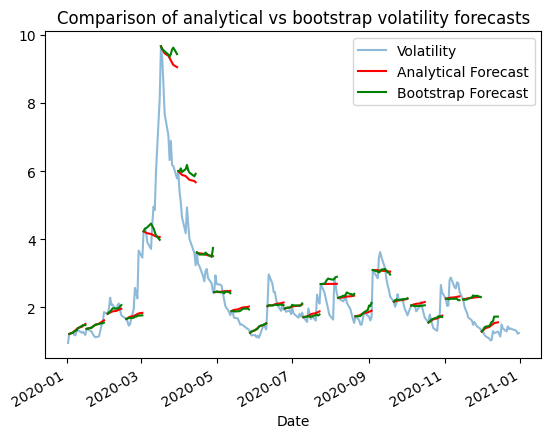

In [62]:
ax = vol.plot(
    title='Comparison of analytical vs bootstrap volatility forecasts',
    alpha=.5
)
ind = vol.index
for i in range(0, 240, 10):
    vol_a = vol_analytic.iloc[i]
    vol_b = vol_bootstrap.iloc[i]
    start_loc = ind.get_loc(vol_a.name)
    new_ind = ind[(start_loc+1):(start_loc+FCST_HORIZON+1)]
    vol_a.index = new_ind
    vol_b.index = new_ind
    ax.plot(vol_a, color='r')
    ax.plot(vol_b, color='g')
labels = ["Volatility", "Analytical Forecast", "Bootstrap Forecast"]
legend = ax.legend(labels)

<div class='alert alert-info'>
When inspecting a single volatility model at a time, it might be easier to use the hedgehog_plot method of the fitted arch_model to create a similar plot.
</div>

## 使用 CCC-GARCH 模型进行多元波动率预测